이 노트북은 김성훈 교수님의 모두를 위한 딥러닝 강좌 스크립트들을 참고, 재구성하여 만들어졌습니다.


(https://github.com/hunkim/DeepLearningZeroToAll/tree/master/pytorch)

필요한 모듈들을 import합니다.

In [1]:
import torch
# 파이토치 전체 패키지
from torch.autograd import Variable
# 여기선 Data feed를 위한 Placeholder 역할을 합니다.
import torchvision.datasets as dsets
import torchvision.transforms as transforms
# 영상인식에서 대표적인 Dataset인 MNIST를 불러오고 사용하기 편하게 텐서로 변환하기 위한 패키지입니다.
import random
# 재현성을 위해 난수 Seed를 고정하기 위해 불러오는 패키지입니다.
import torch.nn.init
# Parameter 초기화에 관한 패키지입니다.

하이퍼 패러미터와 난수 Seed를 설정합니다.

In [2]:
torch.manual_seed(777)
# 재현성을 위해 난수를 고정합니다.

# Hyperparameters
# 하이퍼 패러미터란 학습으로 인해 자동으로 최적화되는 값이 아닌,
# 사람이 Huristic하게 최적의 값을 찾아나갈 수 밖에 없는 Parameter들입니다.
learning_rate = 0.001
# 한번에 얼만큼 업데이트 할 것인가에 대한 Hyperparameter입니다.
training_epochs = 15
# 에폭은 전체 데이터셋의 크기 만큼의 한 Loop를 일컫는 단위입니다. 총 몇 에폭 돌지 설정합니다.
batch_size = 100
# 한번에 Feed하는 이미지의 갯수를 결정합니다.
# 초심자 단계에서 당장 신경쓸 필요는 없지만 배치사이즈는 학습속도 뿐만 아니라 최종적인 성능에도 상당한 영향을 미친다고 알려져 있습니다.
keep_prob = 0.7
# Dropout을 할 때 얼만큼 데이터를 보존할 지 결정하는 Parameter입니다.
# (1 - keep_prob)만큼 학습시에 데이터를 탈락시킵니다.

데이터를 불러오기 위해 DataLoader를 설정합니다.

In [3]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)
# Trainig Dataset입니다.

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)
# Test Dataset입니다.

data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)
# 파이토치에서 지원하는 데이터로더를 사용합니다.
# dataset은 사용할 데이터셋
# batch_size는 한번에 불러올 배치사이즈
# shuffle은 Index를 섞을지 말지 결정합니다.

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


모델을 구성합니다. 딥러닝 소스코드의 심장에 해당하는 부분입니다.


단순 일방향 Feeding 구조를 가진 모델을 구현할 때는 파이토치의 Sequential API를 사용하면 매우 편리합니다.

In [4]:
linear1 = torch.nn.Linear(784, 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 10, bias=True)
# Fully Connected Layer들을 정의합니다. 아직 서로가 연결된 상태는 아닙니다.

relu = torch.nn.ReLU()
# 활성화 함수인 Relu를 정의합니다.

dropout = torch.nn.Dropout(p=1 - keep_prob)
# Regularization을 위해 Dropout을 정의합니다.

torch.nn.init.normal_(linear1.weight)
torch.nn.init.normal_(linear2.weight)
torch.nn.init.normal_(linear3.weight)
torch.nn.init.normal_(linear4.weight)
torch.nn.init.normal_(linear5.weight)
# Weight들을 정규분포에서 초기화합니다.
# Bias들은 별도로 지정하지 않으면 0으로 초기화됩니다.

model = torch.nn.Sequential(linear1, relu, dropout,
                            linear2, relu, dropout,
                            linear3, relu, dropout,
                            linear4, relu, dropout,
                            linear5)
# torch.nn.Sequential API를 사용해 레이어들을 서로 연결합니다.

criterion = torch.nn.CrossEntropyLoss()
# Loss Function을 정의합니다. 
# Criterion = 척도 (Objective Function으로 직접 사용할 수 있는 척도)
# Metric = 척도 (Objective Function으로 직접 사용할 수 있을 수도 있고 없을 수도 있음)
# Softmax 함수는 torch.nn.CrossEntropyLoss안에 내부적으로 포함되어 있으므로 생략해도 됩니다.

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 최적화엔 Adam Optimizer를 사용합니다.
# model.parameters()로 Model에 등록된 학습가능한 모든 Parameter들을 불러오고
# lr=learning_rate로 Hyperparameter인 Learning Rate를 입력해줍니다.

GPU 가속을 위해 모델을 GPU로 옮겨줍니다.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# CUDA 디바이스가 사용가능하면 device에 cuda:0가 반환될 것입니다.
print(device)
# print해서 제대로 cuda:0가 반환되었는지 확인합니다.

model.to(device)
# 모델을 GPU상에서 연산되게 올려줍니다.

cuda:0


/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.30000000000000004, inplace=False)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.30000000000000004, inplace=False)
  (6): Linear(in_features=512, out_features=512, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.30000000000000004, inplace=False)
  (9): Linear(in_features=512, out_features=512, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.30000000000000004, inplace=False)
  (12): Linear(in_features=512, out_features=10, bias=True)
)

트레이닝 루프를 만들어 줍니다. 실질적으로 학습이 진행되는 부분입니다.

In [6]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(mnist_train) // batch_size
    # '전체 데이터셋 길이'를 '한번에 Feed하는 배치사이즈'로 나누면
    # 한 에폭을 돌기위해 반복해야 할 루프횟수(total_batch)가 됩니다.

    for i, (batch_xs, batch_ys) in enumerate(data_loader): 
        X = batch_xs.view(-1, 28 * 28).to(device)
        # Fully Connected Layer에 Feed하기 위해 이미지를 1자로 펴줍니다. GPU로 보내줍니다.
        Y = batch_ys.to(device)
        # torch.nn.CrossEntropyLoss() 함수 사용시엔 원핫인코딩되지 않은 레이블을 넣습니다. GPU로 보내줍니다.

        optimizer.zero_grad()
        # 매 루프 시마다 각 Variable(Layer에 소속된 Variable 포함)에 등록된 grad를 0으로 만들어 줍니다.
        hypothesis = model(X)
        # hypothesis는 말 그대로 가설입니다. 내 모델을 통해 예측한 예측값(가설)이라고 생각하면 됩니다.
        # Softmax를 거치기 전 Logit도 가설이라고 할 수 있고 Softmax를 거친 확률 값도 가설이라고 할 수 있습니다.
        cost = criterion(hypothesis, Y)
        # Loss Function을 거친 뒤 나온 '실제 정답값과의 차이'를 구합니다.
        cost.backward()
        # '실제 정답값과의 차이'를 모델에 속한 각 Variable들로 편미분한 값을 각 Variable에 전달하는 과정이 내부적으로 진행됩니다.
        optimizer.step()
        # 각 Variable에 등록된 grad를 이용해 Weight 값을 Adam Optimization 방법으로 업데이트합니다.

        avg_cost += cost / total_batch
        # '실제 정답값과의 차이'가 얼마나 줄어들었는지 실시간으로 확인하기 위해 따로 기록해둡니다.

    print("[Epoch: %7d] cost = %5.5f"%(epoch + 1, avg_cost.item()))
    # '실제 정답값과의 차이'가 얼마나 줄어들었는지 실시간으로 확인합니다.

print('Learning Finished!')

[Epoch:       1] cost = 306014.03125
[Epoch:       2] cost = 75055.14844
[Epoch:       3] cost = 42842.69922
[Epoch:       4] cost = 28179.15625
[Epoch:       5] cost = 20148.99805
[Epoch:       6] cost = 14711.35645
[Epoch:       7] cost = 11064.28027
[Epoch:       8] cost = 8604.91016
[Epoch:       9] cost = 6366.82129
[Epoch:      10] cost = 4828.05322
[Epoch:      11] cost = 3646.98804
[Epoch:      12] cost = 2725.77539
[Epoch:      13] cost = 1971.27588
[Epoch:      14] cost = 1371.91650
[Epoch:      15] cost = 907.93207
Learning Finished!


학습이 완료된 모델을 이용해 정확도(Accuracy)를 구해봅니다.

In [7]:
model.eval()
# 모델을 Evaluation 모드로 바꿔줍니다.
# 반대로 Training 모드로 바꿔줄려면 model.train()을 사용합니다.
# 이 함수는 torch.nn 패키지를 통해 만들어진 
# Batchnormalization 패러미터를 이동평균으로 바꿔주거나 Dropout을 없애주는 등의 역할을 수행합니다.
# 만약 이 함수로 인해 영향받지 않는 Layer를 만들고 싶다면 torch.nn.functional 패키지를 사용합니다.

X_test = Variable(mnist_test.test_data.view(-1, 28 * 28).float()).to(device)
# 테스트 데이터 입력을 1자로 펴서 Placeholder에 넣습니다.
Y_test = Variable(mnist_test.test_labels).to(device)
# 테스트 데이터 출력을 Placeholder에 넣습니다.

prediction = model(X_test)
# 가설(예측 값)을 구합니다.
correct_prediction = (torch.max(prediction.data, 1)[1] == Y_test.data)
# torch.max(prediction.data, 1)[1] : 확률이 가장 높은 값의 Index를 취합니다.(argmax)
# == Y_test.data : 정답값과 비교합니다.
accuracy = correct_prediction.float().mean()
# Bool형식 데이터를 Float형식으로 바꾼 뒤 전체의 평균을 취하면 정확도를 구할 수 있습니다.
print('Accuracy:', accuracy.item())
# 정확도를 출력합니다.

Accuracy: 0.8327999711036682


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


모델이 잘 작동하는지 예시 하나를 직접 눈으로 확인합니다

In [8]:
r = random.randint(0, len(mnist_test) - 1)
X_single_data = Variable(mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float()).to(device)
Y_single_data = Variable(mnist_test.test_labels[r:r + 1]).to(device)
# 랜덤한 값 하나를 고릅니다.

print("Label: ", Y_single_data.item())
single_prediction = model(X_single_data)
print("Prediction: ", torch.max(single_prediction, 1)[1].item())
# 예측값과 정답을 비교해봅니다.

Label:  0
Prediction:  0


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


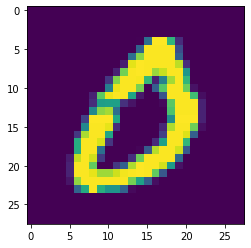

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.squeeze(X_single_data.view(-1, 28, 28).cpu().numpy()))
# 예측에 사용했던 숫자의 이미지를 시각화 해봅니다.

위 과정을 모두 완료하셨으면 오버피팅 현상을 경험해보기 위해 학습을 더 시키고 정확도를 확인해 봅시다.